In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sc
from scipy import stats as st
import seaborn as sns
import statsmodels.api as sm
import arviz as az
import bambi as bmb
import pymc as pm
import pymc.sampling_jax
from pymc import HalfNormal, Model, Normal, sample
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
sns.set_theme(palette="colorblind")

In [3]:
tot_df = pd.read_csv("MehrSongSpelke_exp_1.csv")

In [4]:
tot_df.shape

(96, 153)

In [5]:
print(*tot_df.columns)

id study_code exp1 exp2 exp3 exp4 exp5 dob dot1 dot2 dot3 female dad train Baseline_Proportion_Gaze_to_Singer Familiarization_Gaze_to_Familiar Familiarization_Gaze_to_Unfamiliar Test_Proportion_Gaze_to_Singer Difference_in_Proportion_Looking Estimated_Total_Number_of_Song totskypesing stim othersing comply_no module skype_before ammat ammar ammatot ammapr ipad_num famtot_6 unfamtot_6 totprac totw totnw age length delay mtotsing mbabylike msingcomf mtotrecord m_othersong pright diarymissing comply_fup survey_completion smsingrate smtalkrate gzsingrate gztalkrate famtot unfamtot totsing1 babylike1 singcomf1 totrecord1 othersong1 dtword1 dtnoword1 totsing2 babylike2 singcomf2 totrecord2 othersong2 dtword2 dtnoword2 totsing3 babylike3 singcomf3 totrecord3 othersong3 dtword3 dtnoword3 totsing4 babylike4 singcomf4 totrecord4 othersong4 dtword4 dtnoword4 totsing5 babylike5 singcomf5 totrecord5 othersong5 dtword5 dtnoword5 totsing6 babylike6 singcomf6 totrecord6 othersong6 dtword6 dtnoword6 to

In [6]:
tot_df["exp1"].unique()

array([1, 0])

In [7]:
df = tot_df[tot_df["exp1"] == 1]
df.shape

(32, 153)

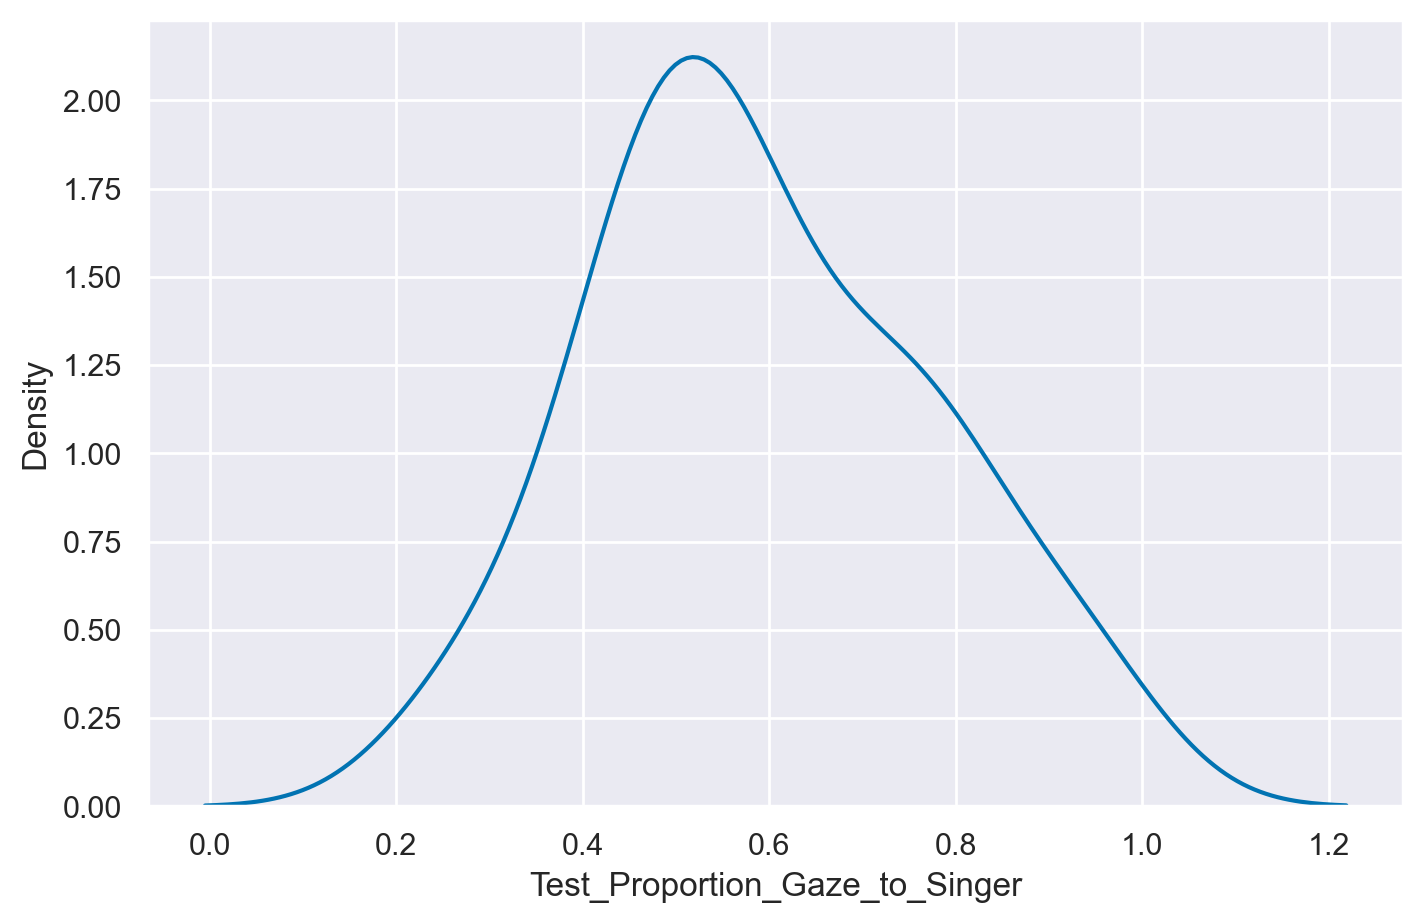

In [8]:
plt.figure(figsize=(7, 4.5))
_ = sns.kdeplot(data=df, x="Test_Proportion_Gaze_to_Singer")

In [9]:
summary_stats = [min, np.median, np.mean, np.std, max]
print(df["Test_Proportion_Gaze_to_Singer"].aggregate(summary_stats))

min       0.262846
median    0.556953
mean      0.593491
std       0.178688
max       0.950920
Name: Test_Proportion_Gaze_to_Singer, dtype: float64


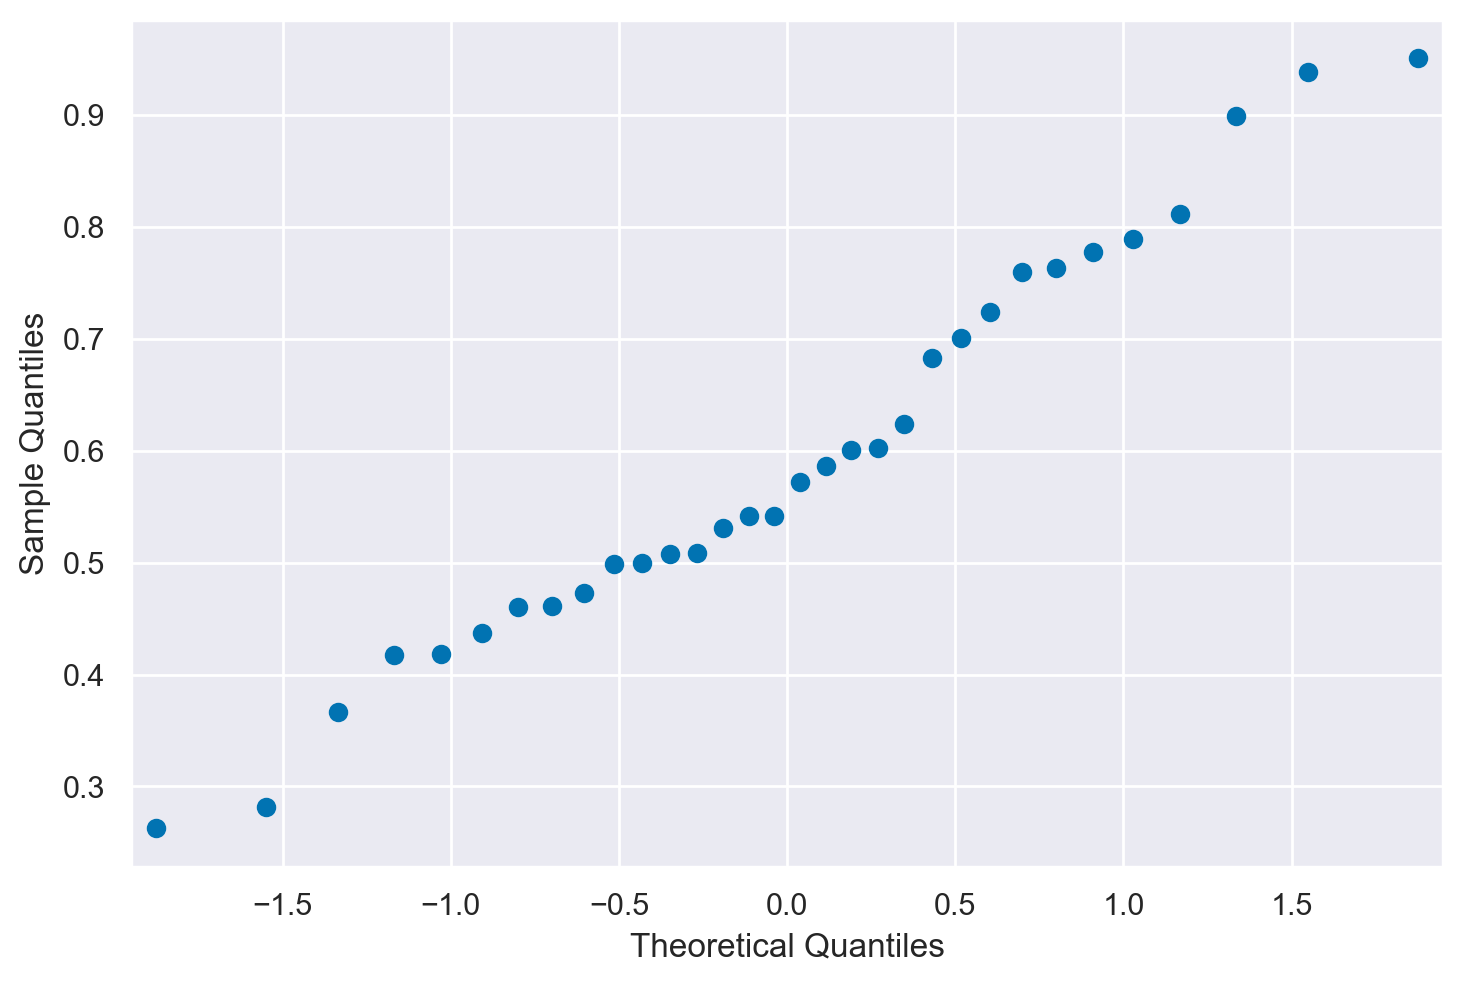

In [10]:
_ = sm.qqplot(df["Test_Proportion_Gaze_to_Singer"])

In [11]:
m = df["Test_Proportion_Gaze_to_Singer"].mean()
m

0.59349125

In [12]:
n = len(df["Test_Proportion_Gaze_to_Singer"])
s = np.std(df["Test_Proportion_Gaze_to_Singer"], ddof=1)
std_err = s / np.sqrt(n)
std_err

0.03158793887638613

In [13]:
T = (m - 0.5) / std_err
T

2.959713527554351

In [14]:
dof = n - 1
dof

31

In [15]:
2 * (1 - st.t.cdf(T, n - 1))

0.005855685399372312

In [16]:
st.ttest_1samp(a=df["Test_Proportion_Gaze_to_Singer"], popmean=0.5)

TtestResult(statistic=2.959713527554351, pvalue=0.00585568539937219, df=31)

In [17]:
[m + sign * st.t.ppf(0.975, n - 1) * std_err for sign in [-1, 1]]

[0.5290672239176627, 0.6579152760823374]

In [18]:
round((m - 0.5) / np.std(df["Test_Proportion_Gaze_to_Singer"], ddof=1), 2)

0.52

In [19]:
y = df["Test_Proportion_Gaze_to_Singer"]

In [20]:
with pm.Model() as model1:

    # Priors
    mu = pm.Normal("mu", mu=0.5, sigma=0.5)
    sigma = pm.HalfCauchy("sigma", beta=1)
    # Likelihood of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=y)

In [21]:
with model1:
    trace1 = pm.sampling_jax.sample_numpyro_nuts(draws=2000, tune=1000)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

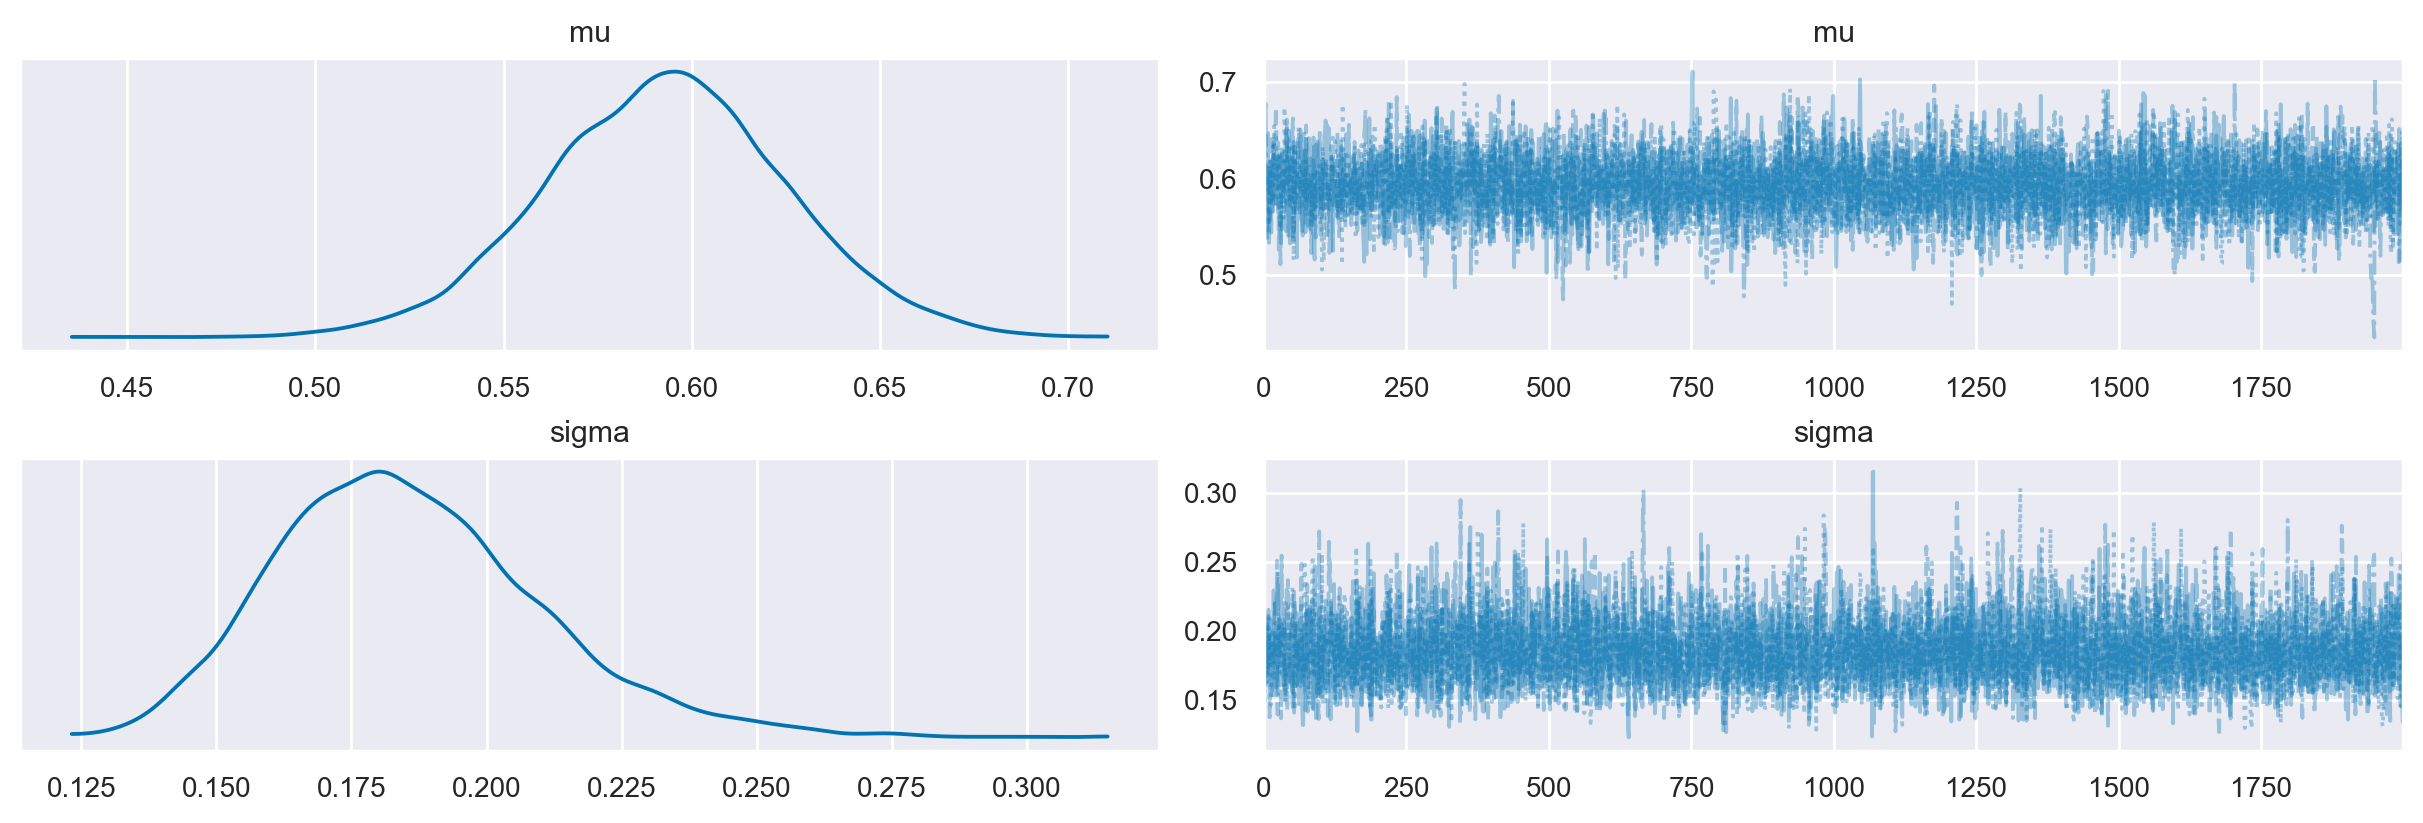

In [22]:
az.plot_trace(trace1, combined=True);

In [23]:
az.summary(trace1, hdi_prob=0.95, round_to=3)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.593,0.032,0.526,0.654,0.0,0.0,5495.539,4255.170,1.0
sigma,0.186,0.025,0.142,0.236,0.0,0.0,5478.536,4979.301,1.0


In [24]:
with pm.Model() as model2:

    # Priors 
    mu = pm.Beta("mu", alpha=2, beta=2)
    sigma = pm.HalfCauchy("sigma", beta=1)
    # Likelihood of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=y)

In [25]:
with model2:
    trace2 = pm.sampling_jax.sample_numpyro_nuts(draws=2000, tune=1000)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [26]:
az.summary(trace2, hdi_prob=0.95, round_to=3)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.593,0.033,0.528,0.659,0.0,0.0,6180.040,5174.873,1.001
sigma,0.186,0.025,0.143,0.236,0.0,0.0,5662.618,5169.695,1.001


In [27]:
y = [df["Baseline_Proportion_Gaze_to_Singer"], df["Test_Proportion_Gaze_to_Singer"]]
y = [item for sublist in y for item in sublist]
group = [
    ["baseline"] * len(df["Baseline_Proportion_Gaze_to_Singer"]),
    ["test"] * len(df["Test_Proportion_Gaze_to_Singer"]),
]
grp = [item for sublist in group for item in sublist]
mydata = pd.DataFrame()
mydata["group"] = grp
mydata["y"] = y
mydata.head()

,group,y
0,baseline,0.437126
1,baseline,0.412533
2,baseline,0.754491
3,baseline,0.438878
4,baseline,0.474645


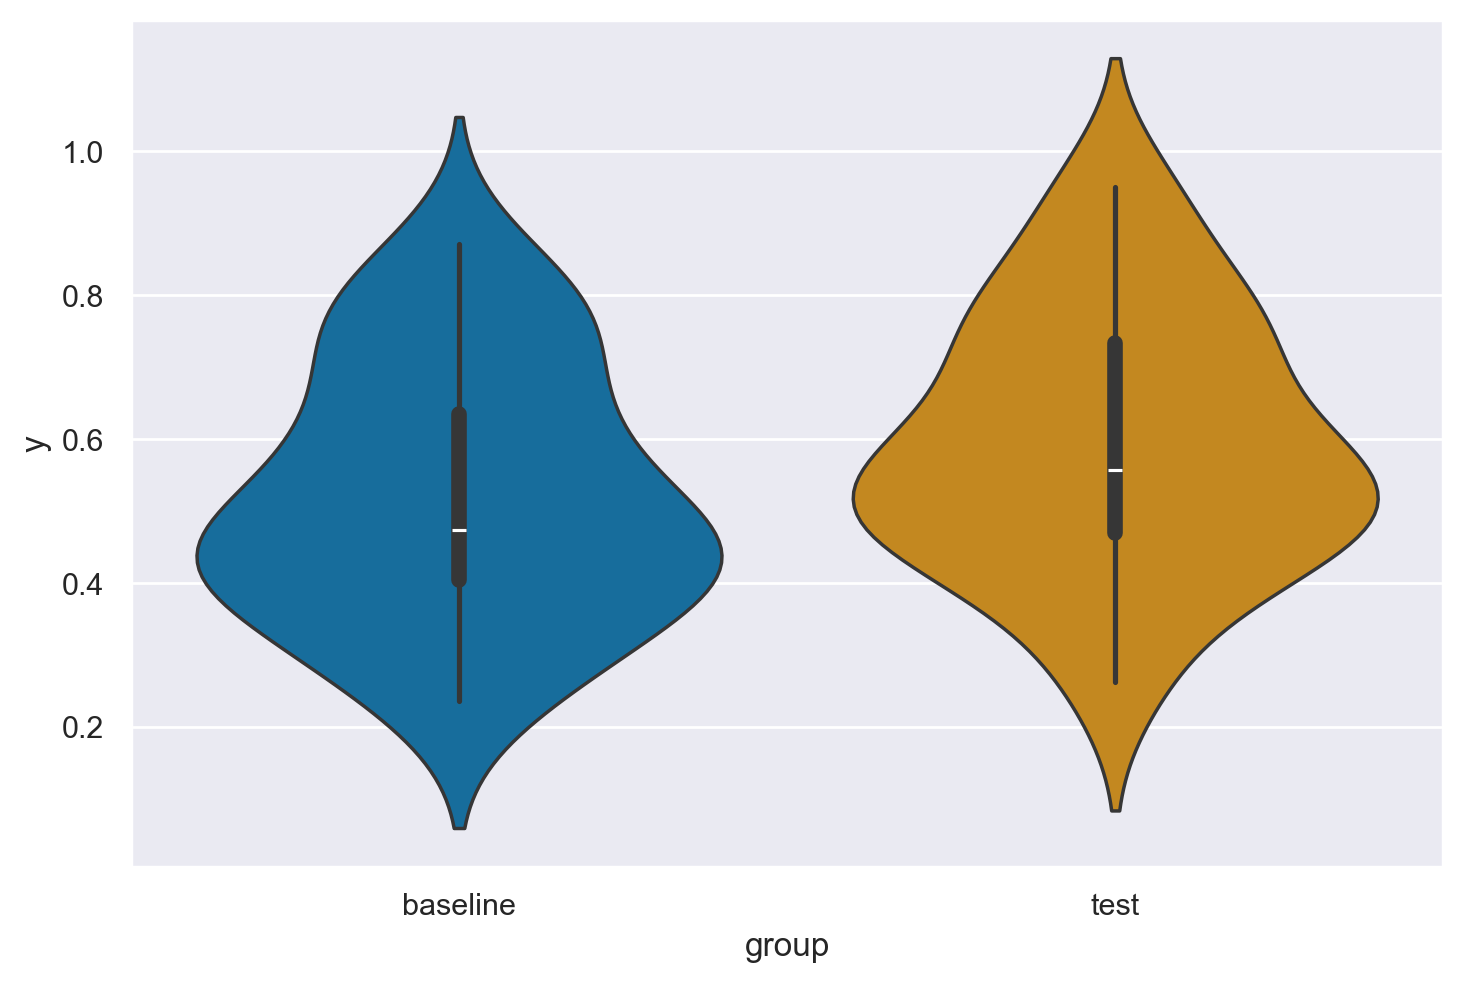

In [28]:
sns.violinplot(x="group", y="y", hue="group", data=mydata)
plt.legend([], [], frameon=False);

In [29]:
diff = df["Test_Proportion_Gaze_to_Singer"] - df["Baseline_Proportion_Gaze_to_Singer"]
diff

0     0.165614
1     0.270494
2    -0.030353
3    -0.157224
4     0.023897
5     0.080019
6     0.181040
7     0.178943
8     0.083665
9    -0.213239
10    0.093946
11   -0.189512
12    0.217782
13   -0.043105
14    0.162541
15   -0.053986
16    0.197520
17   -0.067392
18    0.072766
19    0.096815
20   -0.145358
21    0.532836
22    0.060108
23    0.241541
24   -0.005447
25    0.177075
26    0.131705
27    0.057314
28   -0.279319
29    0.110225
30    0.340925
31    0.024790
dtype: float64

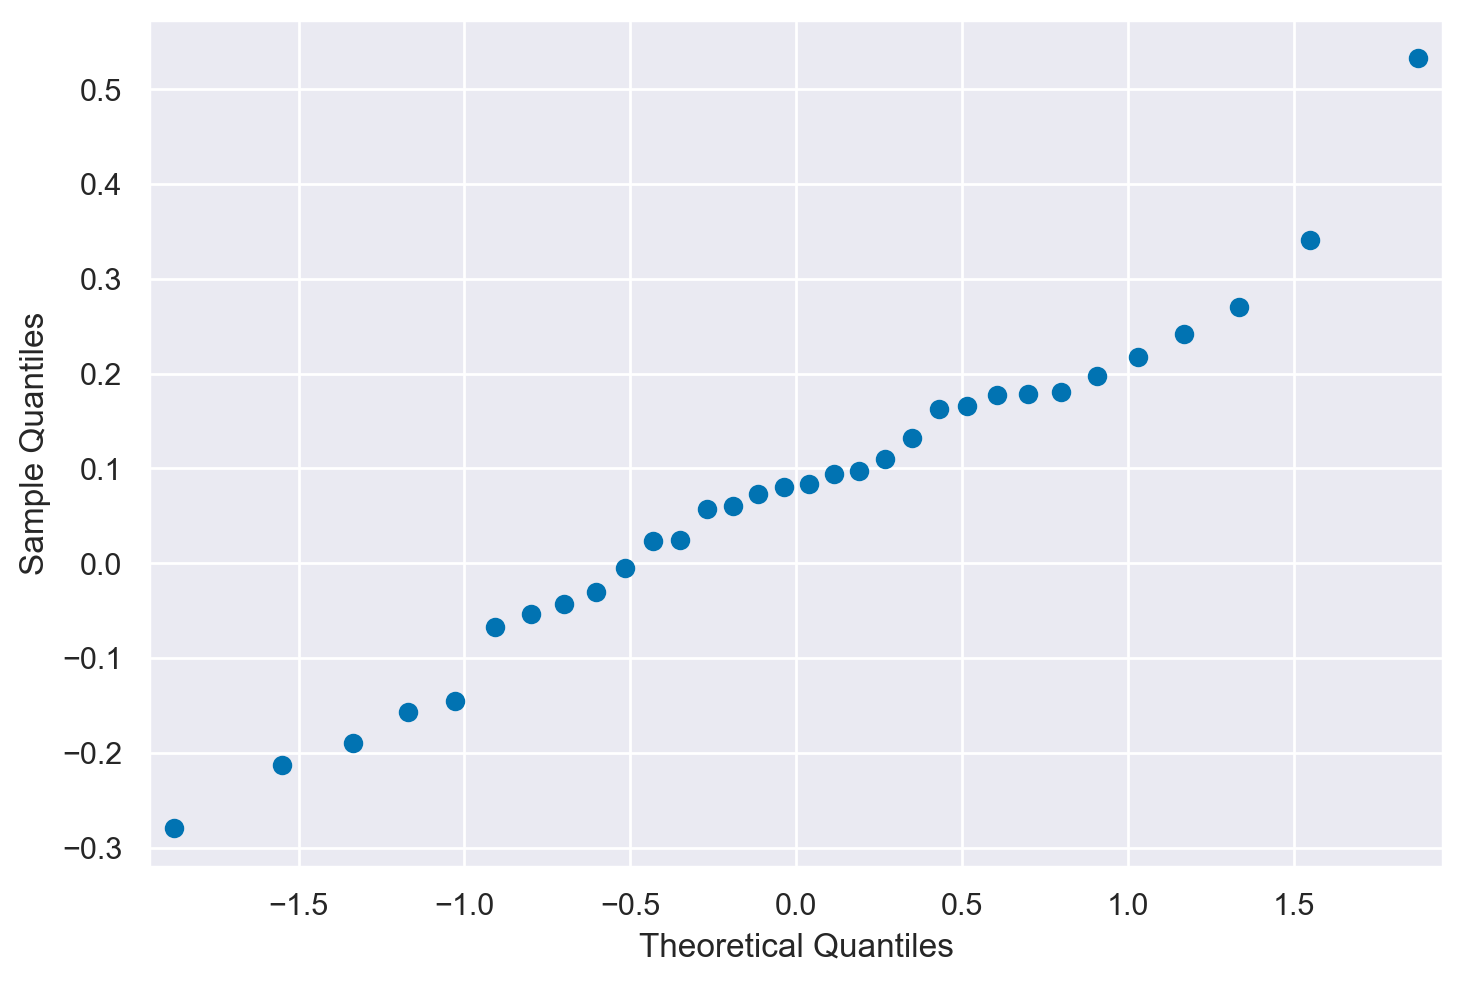

In [30]:
sm.qqplot(diff);

In [31]:
m = np.mean(diff)
m

0.07239457500000002

In [32]:
n = len(diff)
s = np.std(diff, ddof=1)
std_err = s / np.sqrt(n)
std_err

0.02995930592625408

In [33]:
T = (m - 0) / std_err
T

2.4164303131121225

In [34]:
2 * (1 - st.t.cdf(T, len(diff) - 1))

0.0217529308405513

In [35]:
[m + sign * st.t.ppf(0.975, len(diff) - 1) * std_err for sign in [-1, 1]]

[0.011292167718701236, 0.1334969822812988]

In [36]:
d = np.mean(diff) / np.std(diff)
d

0.434003696213157

In [37]:
with pm.Model() as model3:

    # Priors
    mu = pm.Beta("mu", alpha=2, beta=2)
    sigma = pm.HalfCauchy("sigma", beta=1)
    # Likelihood of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=diff)

In [38]:
with model3:
    trace3 = pm.sampling_jax.sample_numpyro_nuts(draws=2000, tune=1000)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [39]:
az.summary(trace3, hdi_prob=0.95, round_to=3)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.085,0.029,0.027,0.141,0.0,0.0,4227.408,2794.275,1.001
sigma,0.177,0.024,0.133,0.225,0.0,0.0,4176.200,4258.676,1.000


In [40]:
0.084 / 0.176

0.47727272727272735

In [41]:
y = df['Difference_in_Proportion_Looking']

In [42]:
x = df["Estimated_Total_Number_of_Song"]
x = np.log2(x)
[np.min(x), np.max(x)]

[3.700439718141092, 7.936637939002571]

Text(0.5, 0, 'Estimated Number of Times Infant Heard Song ($\\log_2$)')

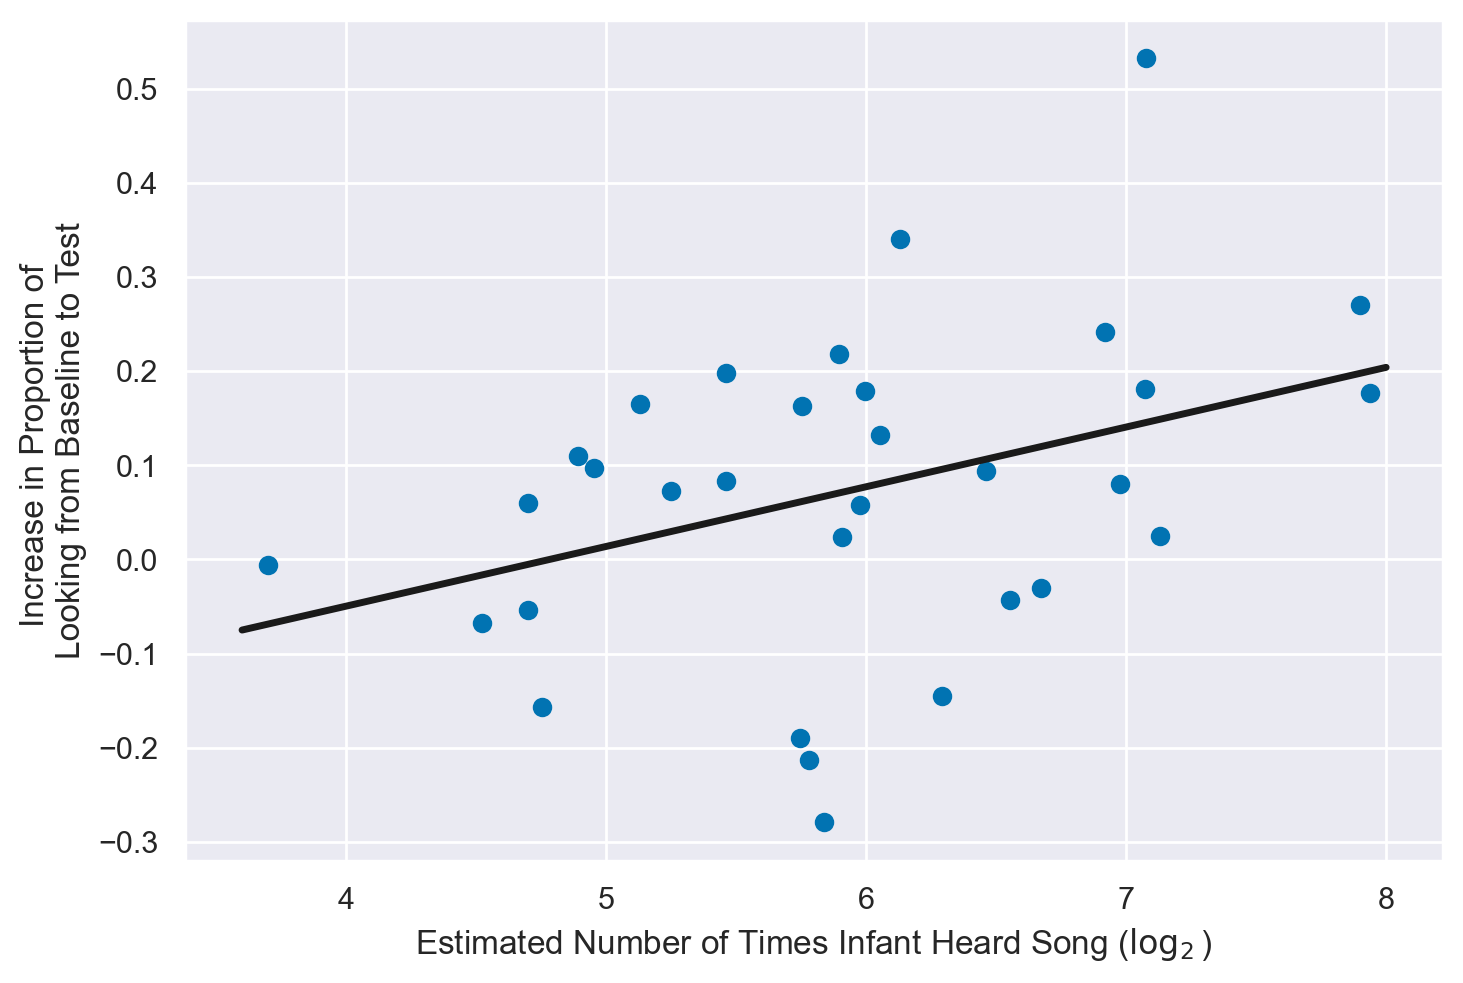

In [43]:
# Create a new figure and a set of subplots (which includes the axes)
fig, ax = plt.subplots()

# Add scatterplot
ax.plot(x, y, "o")

# Fit linear regression via least squares with numpy.polyfit
# It returns a slope (b) and intercept (a)
# deg=1 means linear fit (i.e. polynomial of degree 1)
b, a = np.polyfit(x, y, deg=1)

# Create sequence of 100 numbers from 3.6 to 8
xseq = np.linspace(3.6, 8, num=100)

# Plot regression line
ax.plot(xseq, a + b * xseq, color="k", lw=2.5)

# Set the y-axis label
ax.set_ylabel("Increase in Proportion of \nLooking from Baseline to Test")

# Set the x-axis label
ax.set_xlabel("Estimated Number of Times Infant Heard Song ($\log_2$)")

In [44]:
from statsmodels.formula.api import ols

model = ols("y ~ x", df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     4.793
Date:                Sun, 16 Jun 2024   Prob (F-statistic):             0.0365
Time:                        09:43:02   Log-Likelihood:                 14.275
No. Observations:                  32   AIC:                            -24.55
Df Residuals:                      30   BIC:                            -21.62
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3034      0.174     -1.744      0.0

In [45]:
with Model() as model4:

    # Define priors
    alpha = pm.Normal("alpha", mu=0, sigma=2)
    beta = pm.Normal("beta", mu=0, sigma=2)
    sigma = pm.HalfCauchy("sigma", beta=2)
    # Expected value of outcome
    mu = alpha + beta * x
    # Likelihood of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=y)

In [46]:
with model4:
    trace4 = pm.sampling_jax.sample_numpyro_nuts(draws=2000, tune=1000)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

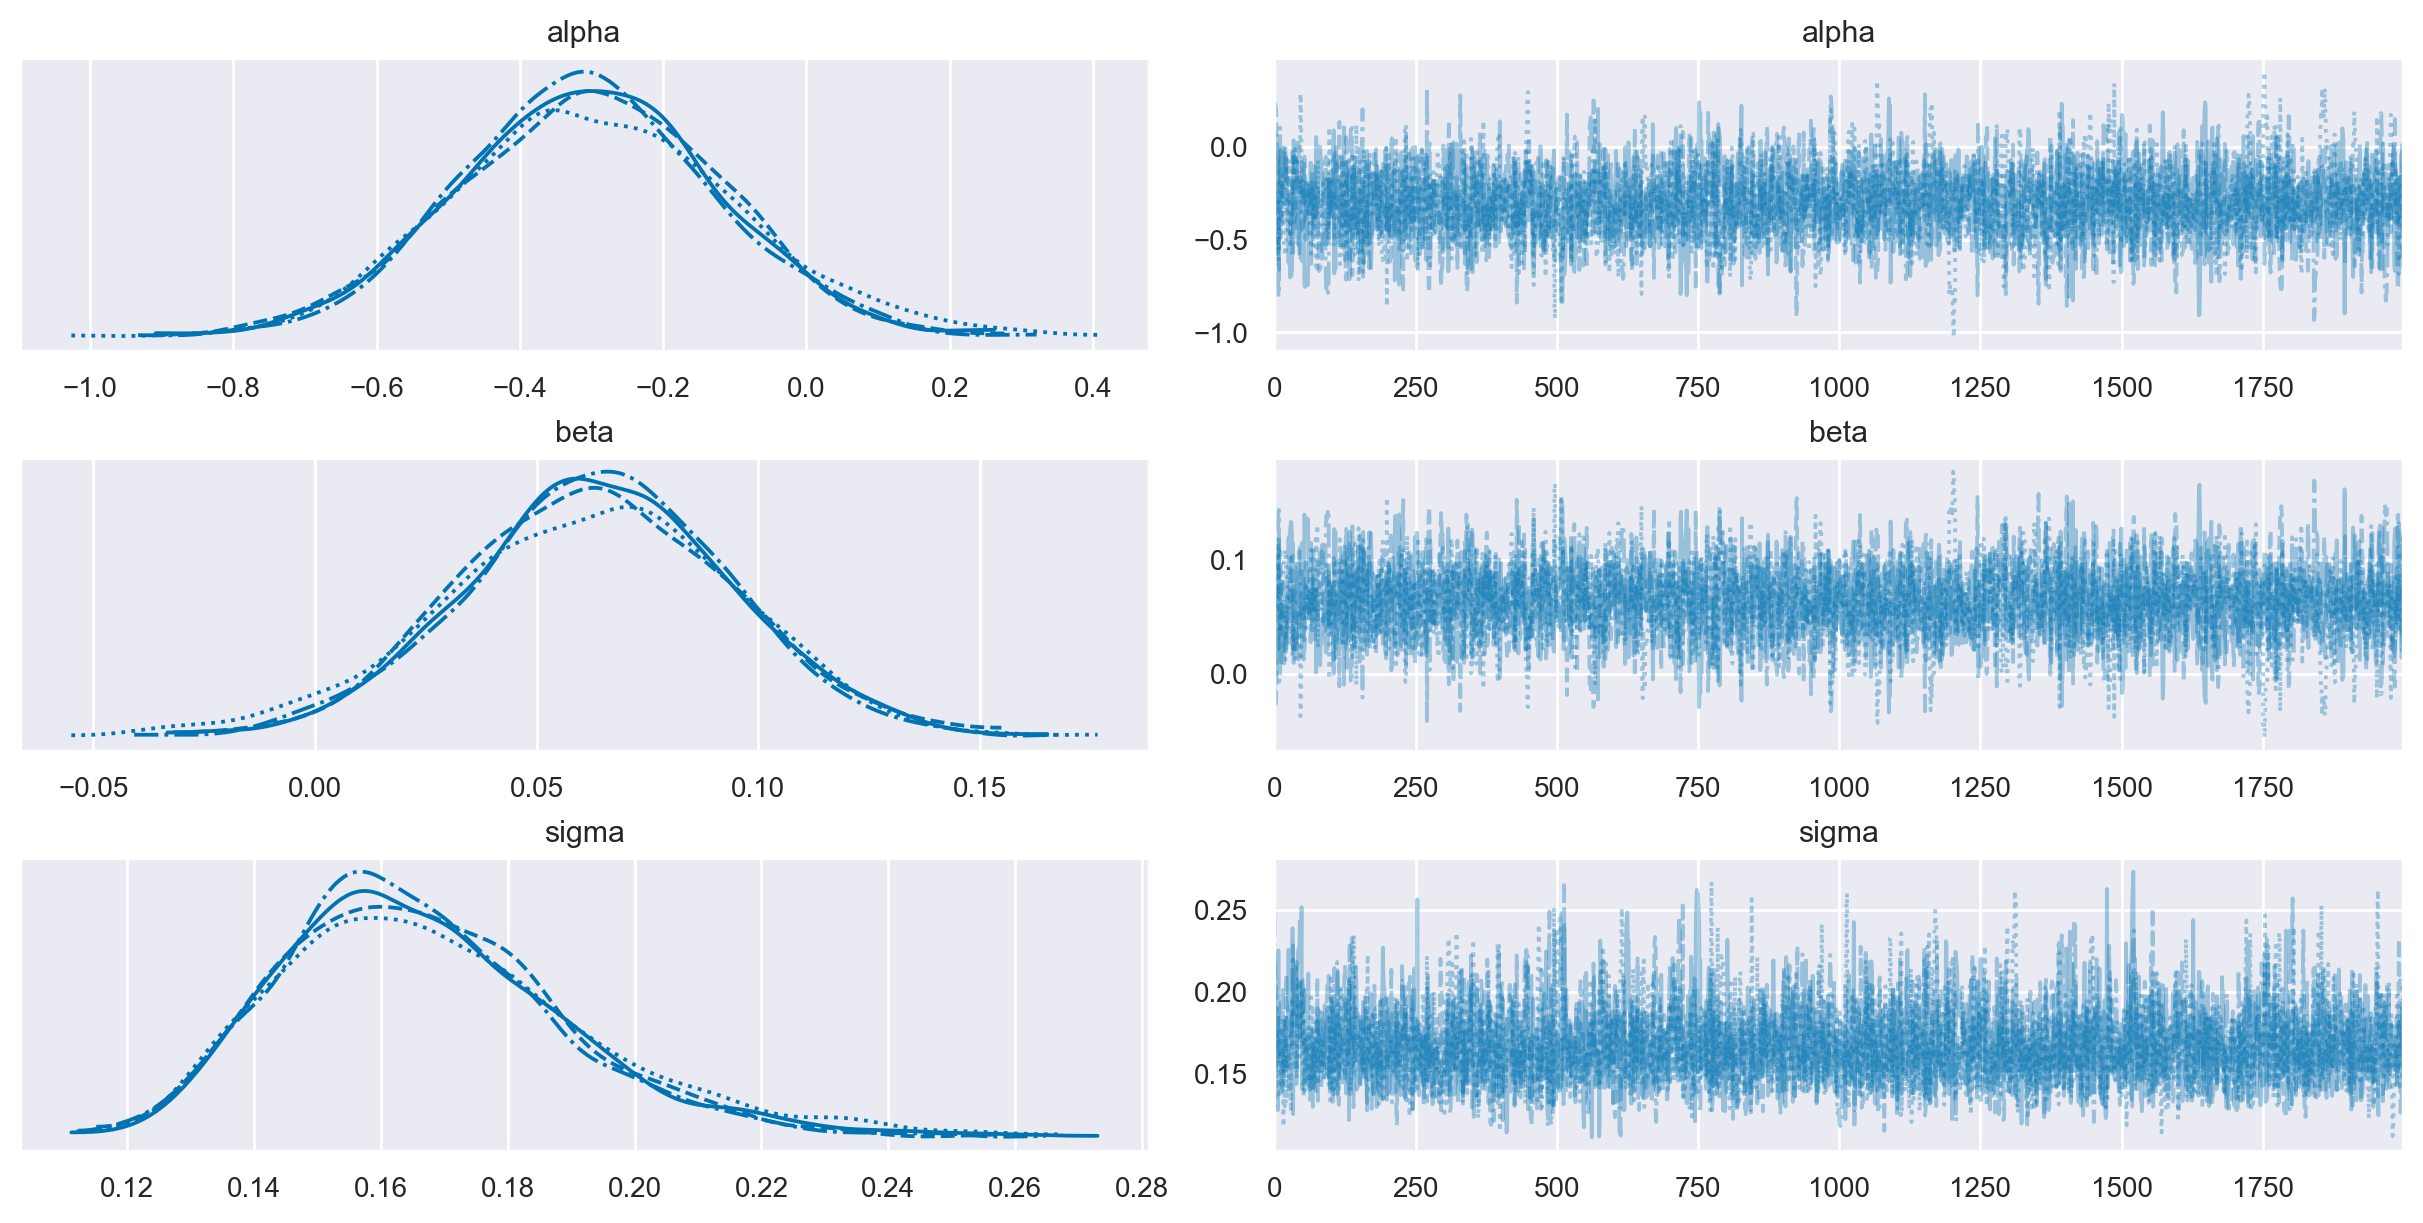

In [47]:
var_names = ["alpha", "beta", "sigma"]
az.plot_trace(trace4, var_names=var_names);

In [48]:
az.summary(trace4, hdi_prob=0.95, round_to=4)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.3029,0.1863,-0.6715,0.0583,0.0039,0.0028,2260.9949,2286.5900,1.0026
beta,0.0633,0.0310,0.0027,0.1246,0.0007,0.0005,2263.4342,2520.4761,1.0026
sigma,0.1670,0.0230,0.1269,0.2139,0.0004,0.0003,2941.7287,2604.9238,1.0017


In [49]:
%load_ext watermark
%watermark -n -u -v -iv -w -m

Last updated: Sun Jun 16 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.25.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

matplotlib : 3.8.4
pymc       : 5.15.1
seaborn    : 0.13.2
arviz      : 0.18.0
bambi      : 0.13.0
statsmodels: 0.14.2
scipy      : 1.13.1
pandas     : 2.2.2
numpy      : 1.26.4

Watermark: 2.4.3

